<a href="https://colab.research.google.com/github/samantha-isaac/Emotion-Detection-in-Images-and-Music-Pairing-Through-AI/blob/main/CNN_Baseline_Landscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Baseline for Landscape Dataset
Samantha Isaac

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# This is to mount Drive to this project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connect to My Drive
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# Path to the folder for the Landscape dataset
dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Landscapes'

In [ ]:
# This function helps load the images and assigns as the labels the name of the correspodning folder
# References used for the function with os: https://docs.python.org/3/library/os.html
def load_images_and_labels(folder_path):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)

    for sub_folder in sub_folders:
        label = sub_folder # In here is where the name of the sub folders is taken as the label
        image_files = os.listdir(os.path.join(folder_path, sub_folder))

        for image_file in image_files:
            image_path = os.path.join(folder_path, sub_folder, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # It reads the images in BGR
            if image is not None:
                image = cv2.resize(image, (128, 128))  # Redimention the images
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # This is to convert from BGR to RGB
                # Reference for this: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
                images.append(image)
                labels.append(label)

    return np.array(images), labels

In [ ]:
# To load images and labels
images, labels = load_images_and_labels(dataset_folder)

In [ ]:
# To create the training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.3, random_state = 42, stratify = labels)

In [ ]:
# To crerate a dictionary that assigns a numeric value to each label
label_map = {label: idx for idx, label in enumerate(set(train_labels))}
# For both training and testing dataset, it replace the label with the correspodning numeric value stablich in the line above
train_labels_numeric = [label_map[label] for label in train_labels]
test_labels_numeric = [label_map[label] for label in test_labels]

In [ ]:
# Convert labels to one-hot encoding. Reference from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
num_classes = len(label_map)
train_labels_encoded = to_categorical(train_labels_numeric, num_classes=num_classes)
test_labels_encoded = to_categorical(test_labels_numeric, num_classes=num_classes)

In [ ]:
# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
train_images = train_images / 255.0
test_images = test_images / 255.0

# To verify that the asignation of the values was made correctly
print("Mapping of labels to numeric values:")
print(label_map)

Mapping of labels to numeric values:
{'sadness': 0, 'melancholy': 1, 'joy': 2, 'liveliness': 3}



Showing images of the class: sadness

Showing images of the class: melancholy

Showing images of the class: joy

Showing images of the class: liveliness


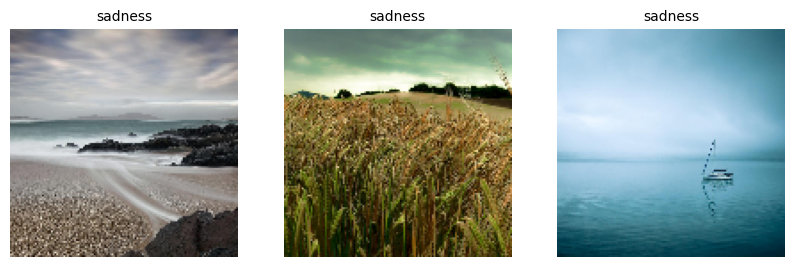

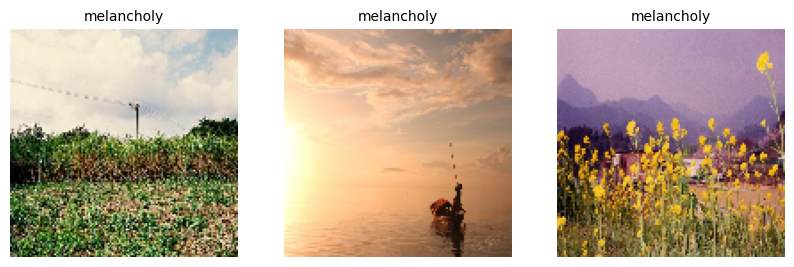

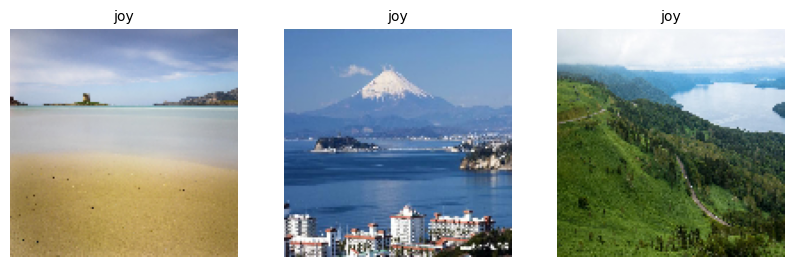

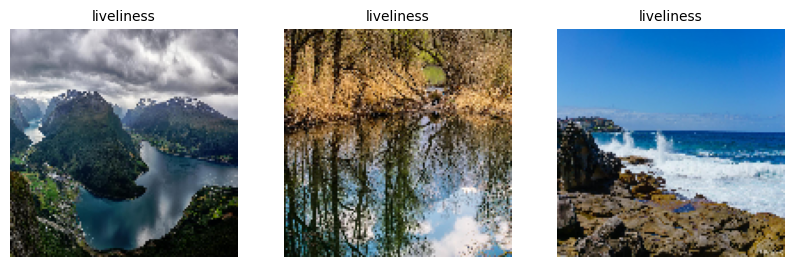

In [ ]:
# This was an extra added to improve the generalisability of the model, generating new modified versions of the images
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

datagen.fit(train_images)

# This is to show a few images to visually verify the images and the labels
def show_images_per_class(images, labels, clase, num_imagenes = 3):
    print(f"\nShowing images of the class: {clase}") # This line was added to explicitatly indicate which images are being shown
    fig, axes = plt.subplots(1, num_imagenes, figsize = (10, 3)) # Reference from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    # This is to create a list of the specific images
    imagenes_clase = [img for img, lbl in zip(images, labels) if lbl == clase]

# This is to iterate and take only the specific number of images, which is 3
    for i in range(num_imagenes):
        if i < len(imagenes_clase):
            axes[i].imshow(imagenes_clase[i])  # To show the images in a RGB format
            axes[i].axis('off')
            # To add title with the corresponding label of each image
            axes[i].set_title(clase, fontsize=10)
        else:
            axes[i].axis('off')

# To show some images with the corresponding labels
for label in set(train_labels):
    show_images_per_class(train_images, train_labels, label)
plt.show()

In [ ]:
# Stablish the structure of the CNN model. Used a reference for most of the structure of the models
# the project of: https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fael
input = Input(shape = (128, 128, 3))

conv1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), padding = 'same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

flatten = Flatten()(pool3)
dense_1 = Dense(128, activation = 'relu')(flatten)

dropout = Dropout(0.5)(dense_1)

output = Dense(num_classes, activation = "softmax")(dropout)

# To compile the model. Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
model = Model(inputs = input, outputs = output)
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])

model.summary()  # I get a summary of the model architecture. Reference: https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,196 (16.36 MB)

 Trainable params: 4,288,196 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# To train the model, and I specdify the parameters to use. Reference: https://stackoverflow.com/questions/37973005/what-do-model-predict-and-model-fit-do
history = model.fit(
    train_images,
    train_labels_encoded,
    validation_data = (test_images, test_labels_encoded),
    epochs = 15,
    batch_size = 32
)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step - accuracy: 0.3138 - loss: 1.5395 - val_accuracy: 0.3964 - val_loss: 1.2864
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3865 - loss: 1.2734 - val_accuracy: 0.4122 - val_loss: 1.2101
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4586 - loss: 1.2112 - val_accuracy: 0.5203 - val_loss: 1.1099
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4883 - loss: 1.1397 - val_accuracy: 0.5203 - val_loss: 1.0627
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5614 - loss: 1.0635 - val_accuracy: 0.5225 - val_loss: 1.0764
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5765 - loss: 1.0169 - val_accuracy: 0.4955 - val_loss: 1.0932
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5693 - loss: 0.9956 - val_accuracy: 0.5450 - val_loss: 1.0340
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6157 - loss: 0.9794 - val_accuracy: 0.5383 -

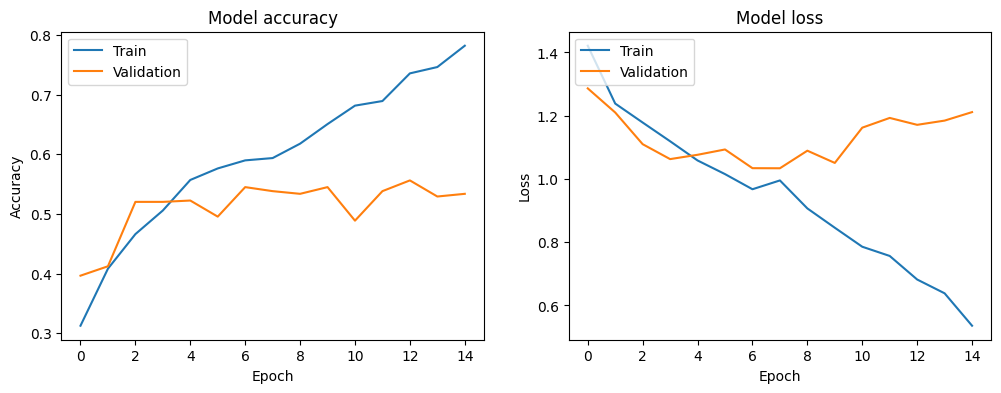

In [ ]:
# This is to visualise the model throughout the training, where accuracy and loss are shown for both training sets
# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.show();

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step


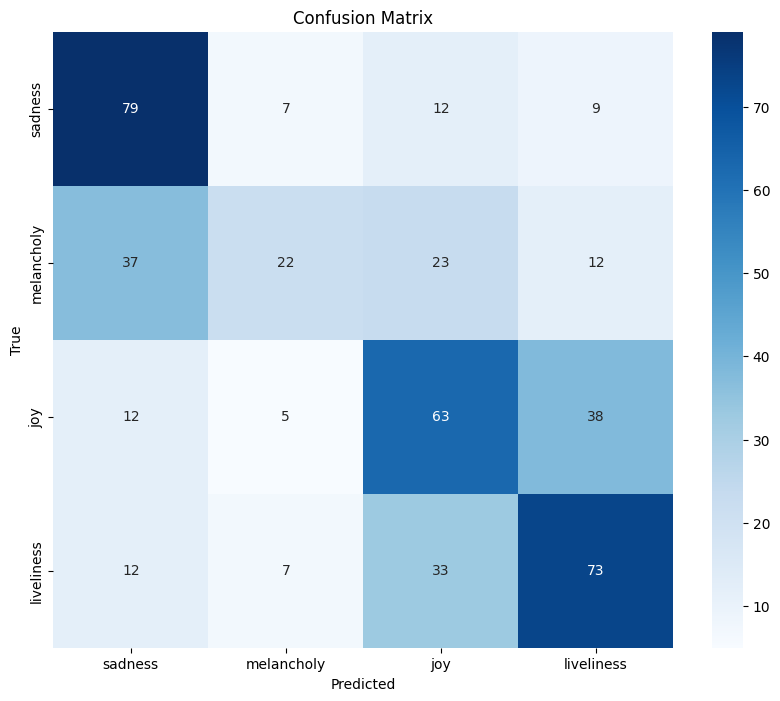

Classification report:
              precision    recall  f1-score   support

     sadness       0.56      0.74      0.64       107
  melancholy       0.54      0.23      0.33        94
         joy       0.48      0.53      0.51       118
  liveliness       0.55      0.58      0.57       125

    accuracy                           0.53       444
   macro avg       0.53      0.52      0.51       444
weighted avg       0.53      0.53      0.52       444



In [ ]:
# This is to evaluate as well the performance of the model with a confusion matrix and a clasification report
# This is for the model to make prediction on the testing images. Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
y_pred_prob = model.predict(test_images)
y_pred_classes = np.argmax(y_pred_prob, axis = 1)
y_true = np.argmax(test_labels_encoded, axis = 1)

# This is for the confusion matrix. Reference: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = abel_map.keys(), yticklabels = label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Show classification report
print("Classification report:")
print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))